# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
embeddings_dir = 'Embeddings/'

labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/ResNet50V2_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = True
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201545  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201547  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201549  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                     6         7      8         9  ...       759      760  \
41001 201545 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201546 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201547 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201548 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201549 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   

                   761       762       763       764       765       766  \
41001 201545  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201547  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201549  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   

                   767    Labels  
41001 201545  0.014199 -0.899881  
      201546  0.014199 -0.861740  
      201547  0.014199 -0.854589  
      201548  0.014199 -0.856973  
      201549  0.014199 -0.856973  

[5 rows x 769 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201545  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201547 -0.320510  0.119825  0.137270  0.216795 -0.476022  0.158546   
     201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201549 -0.444779  0.071139  0.012459 -0.366217 -0.225480 -0.081610   

                    6         7         8         9  ...       759       760  \
5360 201545 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201546 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201547 -0.570430 -0.044212  0.344147 -0.219893  ... -0.319999  0.582625   
     201548 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201549 -0.170546 -0.254429  0.199990 -0.249487  ...  0.342236  0.245481   

                  761       762       763       764       765       766  \
5360 201545  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201547  0.144274 -0.023346  0.200789 -0.030519  0.321033 -0.225532   
     201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201549  0.160376 -0.515343  0.231088  0.428935  0.251430 -0.283586   

                  767    Labels  
5360 201545  0.014199 -0.985697  
     201546  0.014199 -0.990465  
     201547  0.463084 -0.969011  
     201548  0.014199 -0.995232  
     201549  0.161517 -0.997616  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(161, 3076)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1288, 2307)
The shape of the labels is (1288, 1)
Test:
The shape of the features is (322, 2307)
The shape of the labels is (322, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1288, 2307)
The test shape is (322, 2307)
-----------------------
The Final shapes are:
The train shape is (1288, 3, 769)
The test shape is (322, 3, 769)


# 2. Model

In [12]:
x_ar = train_X[:, :, -1:]
x_ar_test = test_X[:, :, -1:]

2023-02-19 19:18:21.678526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-19 19:18:21.678569: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-19 19:18:21.678594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-02-19 19:18:21.678833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 19:18:23.865823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         [(None, 3, 769)]     0                                            
__________________________________________________________________________________________________
lstm_2_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            10

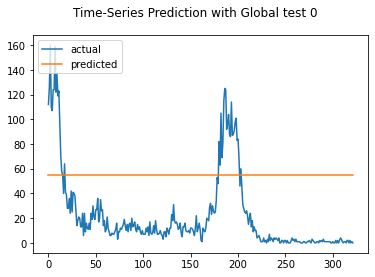

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_4_input (InputLayer)       [(None, 3, 769)]     0                                            
__________________________________________________________________________________________________
lstm_6_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            10240971    lstm_4_input[0][0]               
______________________________________

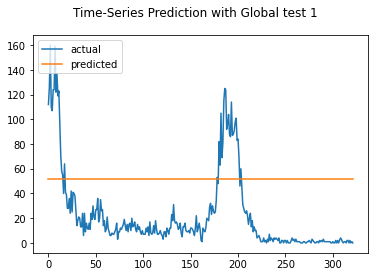

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_8_input (InputLayer)       [(None, 3, 769)]     0                                            
__________________________________________________________________________________________________
lstm_10_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            10240971    lstm_8_input[0][0]               
______________________________________

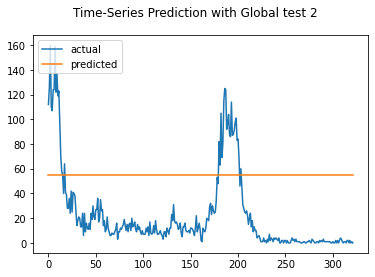

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_12_input (InputLayer)      [(None, 3, 769)]     0                                            
__________________________________________________________________________________________________
lstm_14_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            

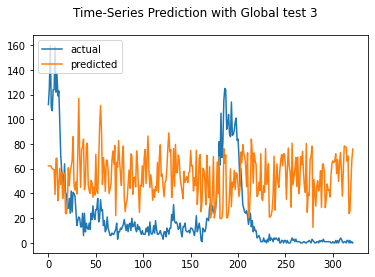

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_16_input (InputLayer)      [(None, 3, 769)]     0                                            
__________________________________________________________________________________________________
lstm_18_input (InputLayer)      [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 1)            

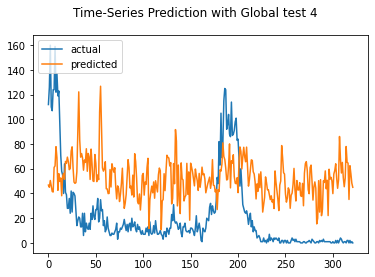

rmse : average=45.936, std=1.761
mape : average=inf, std=nan
smape : average=128.621, std=1.091


([45.93580667910944, 1.7608102522722149],
 [inf, nan],
 [128.62098159511143, 1.090815550643065])

In [13]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=5, plot_samples=True, Municipality='Global', fusion='late', x_ar=x_ar, x_ar_test=x_ar_test)
